In [4]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import cv2
import sklearn
from sklearn.model_selection import StratifiedKFold, GroupKFold

from tqdm.notebook import tqdm

In [5]:
path = 'd:/projects/kaggle/shopee/data/'

In [6]:
    df = pd.read_csv(path + 'train.csv')
    df['image'] = path + 'train_images/' + df['image']
    
    gkf = GroupKFold(n_splits=5)
    df['fold'] = -1
    for fold, (train_idx, valid_idx) in enumerate(gkf.split(df, None, df.label_group)):
        df.loc[valid_idx, 'fold'] = fold

In [7]:
df.to_csv(path + 'folds.csv', index=False)

In [2]:
path = 'data/'
train_path = 'data/train_images/'
test_path = 'data/test_images/'

In [4]:
df = pd.read_csv(path + 'train.csv')
df['image'] = train_path + df['image']
tmp = df.groupby('label_group').posting_id.unique().to_dict()
df['target'] = df.label_group.map(tmp)

# **Utils**

In [6]:
def getMetric(col):
    def f1score(row):
        n = len(np.intersect1d(row.target, row[col]))
        return 2 * n / (len(row.target) + len(row[col]))
    return f1score

# **Image**

**Shape analysis**

In [8]:
shapes = []
for i in tqdm(range(df.shape[0])):
    img = cv2.imread(df['image'].iloc[i])
    shapes.append(img.shape)
df['img_shape'] = shapes

  0%|          | 0/34250 [00:00<?, ?it/s]

In [13]:
df.groupby('label_group').img_shape.unique()

label_group
258047                           [(640, 640, 3), (450, 450, 3)]
297977                           [(500, 500, 3), (764, 764, 3)]
645628        [(800, 800, 3), (1000, 1000, 3), (640, 640, 3)...
801176                           [(640, 640, 3), (800, 800, 3)]
887886                                        [(1024, 1024, 3)]
                                    ...                        
4292154092                       [(600, 600, 3), (640, 640, 3)]
4292520070    [(1000, 1000, 3), (550, 550, 3), (640, 640, 3)...
4292939171                       [(640, 640, 3), (700, 700, 3)]
4293276364                     [(1024, 1024, 3), (700, 700, 3)]
4294197112      [(1024, 1024, 3), (954, 954, 3), (800, 800, 3)]
Name: img_shape, Length: 11014, dtype: object

In [41]:
ipath = df[df.img_shape == df.img_shape.max()].image

In [42]:
ipath = ipath.to_list()[0]

In [27]:
from PIL import Image

In [43]:
img = Image.open(ipath).convert('RGB')

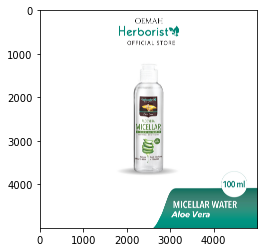

In [44]:
plt.imshow(img)

**Center crop**

In [3]:
from PIL import Image

import torch
torch.manual_seed(1010)


import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data.dataset import Dataset

import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets

from efficientnet_pytorch import EfficientNet

In [46]:
class ShopeeDataset(Dataset):
    def __init__(self, img_path, transform):
        self.img_path = img_path
        self.transform = transform
        
    def __getitem__(self, idx):
        img = Image.open(self.img_path[idx]).convert('RGB')
        img = self.transform(img)
        return img
    
    def __len__(self):
        return len(self.img_path)

In [69]:
shopee_dataset = ShopeeDataset(
    df.image.values,
    transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.CenterCrop((200, 200)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
)

shopee_loader = torch.utils.data.DataLoader(
    shopee_dataset,
    batch_size = 12,
    shuffle = False,
    num_workers = 0
)

In [49]:
class ShopeeNet(nn.Module):
    def __init__(self):
        super(ShopeeNet, self).__init__()

        model = EfficientNet.from_pretrained('efficientnet-b0')
        model.eval()

        self.model = model
        
    def forward(self, img):
        out = self.model.extract_features(img)
        out = self.model._avg_pooling(out)
        return out

In [50]:
shopee_model = ShopeeNet()
shopee_model = shopee_model.to('cuda')

Loaded pretrained weights for efficientnet-b0


In [70]:
embedings = []
with torch.no_grad():
    for data in tqdm(shopee_loader):
        data = data.to('cuda')
        emb = shopee_model(data)
        emb = emb.reshape(emb.shape[0], emb.shape[1])
        emb = emb.data.cpu().numpy()
        
        embedings.append(emb)

  0%|          | 0/2855 [00:00<?, ?it/s]

In [4]:
from sklearn.preprocessing import normalize
from sklearn.neighbors import NearestNeighbors

In [72]:
embedings = np.vstack(embedings)
embedings = normalize(embedings)

In [73]:
distances_cnn = np.matmul(embedings, embedings.T).T

In [75]:
thresholds = list(np.arange(0.7, 1.2, 0.02))
scores = []
for th in thresholds:
    preds = []
    for k in tqdm(range(distances_cnn.shape[0])):
        idx = np.where(distances_cnn[k] > th)[0]
        o = df.iloc[idx].posting_id.values
        preds.append(o)
        
    df[f"cnn"] = preds
    df[f"f1"] = df.apply(getMetric(f"cnn"), axis=1)
    score = df[f'f1'].mean()
    scores.append(score)
    print (f"Threshold: {th}  Score : {score}")
    
print(f"Best threshold: {thresholds[np.argmax(scores)]} Score: {max(scores)}")

  0%|          | 0/34250 [00:00<?, ?it/s]

Threshold: 0.7  Score : 0.5889891902461634


  0%|          | 0/34250 [00:00<?, ?it/s]

Threshold: 0.72  Score : 0.6157923583337427


  0%|          | 0/34250 [00:00<?, ?it/s]

Threshold: 0.74  Score : 0.6359677904267083


  0%|          | 0/34250 [00:00<?, ?it/s]

Threshold: 0.76  Score : 0.6487533840684131


  0%|          | 0/34250 [00:00<?, ?it/s]

Threshold: 0.78  Score : 0.655391057661096


  0%|          | 0/34250 [00:00<?, ?it/s]

Threshold: 0.8  Score : 0.6575095602691384


  0%|          | 0/34250 [00:00<?, ?it/s]

Threshold: 0.8200000000000001  Score : 0.6567522367268264


  0%|          | 0/34250 [00:00<?, ?it/s]

KeyboardInterrupt: 